<a href="https://colab.research.google.com/github/GarouachiMonia/Association-Rules/blob/main/Code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pandas pypdf nltk tqdm sentence-transformers scikit-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 298.0/298.0 kB 4.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
from pypdf import PdfReader
from nltk import pos_tag, sent_tokenize, word_tokenize
from nltk.corpus import stopwords
import string
import re
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import nltk

nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('punkt_tab')
nltk.download('averaged_perceptron_tagger_eng')

/usr/local/lib/python3.10/dist-packages/sentence_transformers/cross_encoder/CrossEncoder.py:13: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger_eng.zip.


True

In [3]:
def extract_text_from_pdf(file_path):
    try:
        reader = PdfReader(file_path)
        text = "".join(page.extract_text() for page in reader.pages)
        return text
    except FileNotFoundError:
        print(f"Le fichier {file_path} n'a pas été trouvé. Il sera ignoré.")
        return None

In [4]:
def preprocess_text(text):
    text = text.lower()  # Conversion en minuscules.
    text = re.sub('[^a-zA-Z]', ' ', text)  # Retirer les caractères spéciaux.
    sentences = sent_tokenize(text)  # Diviser le texte en phrases.
    features = {'feature': ""}
    stop_words = set(stopwords.words("english"))  # Liste des stopwords en anglais.
    for sent in sentences:
        if any(criteria in sent for criteria in ['skills', 'education']):  # Filtrer les phrases pertinentes.
            words = word_tokenize(sent)  # Diviser en mots.
            words = [word for word in words if word not in stop_words]  # Retirer les stopwords.
            tagged_words = pos_tag(words)  # POS tagging.
            filtered_words = [word for word, tag in tagged_words if tag not in ['DT', 'IN', 'TO', 'PRP', 'WP']]
            features['feature'] += " ".join(filtered_words)  # Construction des features.
    return features

In [5]:
def process_resume_data(row):
    id = row['ID']
    category = row['Category']
    file_path = f"/content/drive/MyDrive/data/{category}/{id}.pdf"  # Chemin du fichier PDF.
    text = extract_text_from_pdf(file_path)
    if text:
        features = preprocess_text(text)
        row['Feature'] = features['feature']  # Ajout des features extraites.
    else:
        row['Feature'] = ""  # Valeur vide si extraction impossible.
    return row

In [6]:
def get_embeddings(text, model):
    embeddings = model.encode(text)
    return embeddings

In [7]:
def print_top_matching_resumes(result_group):
    for i in range(15):  # Pour chaque job ID (limité ici à 15).
        print("\nJob ID:", i)
        print("Cosine Similarity | Domain Resume | Domain Description")
        print(result_group.get_group(i)[['similarity', 'domainResume', 'domainDesc']])

In [8]:
resume_data = pd.read_csv("Resume.csv")
resume_data.head(10)

,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR
5,11592605,HR GENERALIST Summary Dedic...,"<div class=""fontsize fontface vmargins hmargin...",HR
6,25824789,HR MANAGER Summary HUMAN RES...,"<div class=""fontsize fontface vmargins hmargin...",HR
7,15375009,HR MANAGER Professional Summa...,"<div class=""fontsize fontface vmargins hmargin...",HR
8,11847784,HR SPECIALIST Summary Posses...,"<div class=""fontsize fontface vmargins hmargin...",HR
9,32896934,HR CLERK Summary Translates ...,"<div class=""fontsize fontface vmargins hmargin...",HR


In [9]:
resume_data = resume_data.drop(["Resume_html"], axis=1)
resume_data.head(10)

,ID,Resume_str,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...",HR
2,33176873,HR DIRECTOR Summary Over 2...,HR
3,27018550,HR SPECIALIST Summary Dedica...,HR
4,17812897,HR MANAGER Skill Highlights ...,HR
5,11592605,HR GENERALIST Summary Dedic...,HR
6,25824789,HR MANAGER Summary HUMAN RES...,HR
7,15375009,HR MANAGER Professional Summa...,HR
8,11847784,HR SPECIALIST Summary Posses...,HR
9,32896934,HR CLERK Summary Translates ...,HR


In [10]:
resume_data = resume_data.apply(process_resume_data, axis=1)
resume_data.head(10)
resume_data.to_csv("/content/drive/MyDrive/resume_data.csv", index=False)

In [11]:
job_description = pd.read_csv("training_data.csv")
job_description.head(10)

,company_name,job_description,position_title,description_length,model_response
0,Google,minimum qualifications\nbachelors degree or eq...,Sales Specialist,2727,"{\n ""Core Responsibilities"": ""Responsible fo..."
1,Apple,description\nas an asc you will be highly infl...,Apple Solutions Consultant,828,"{\n ""Core Responsibilities"": ""as an asc you ..."
2,Netflix,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,3205,"{\n ""Core Responsibilities"": ""Help drive bus..."
3,Robert Half,description\n\nweb designers looking to expand...,Web Designer,2489,"{\n ""Core Responsibilities"": ""Designing webs..."
4,TrackFive,at trackfive weve got big goals were on a miss...,Web Developer,3167,"{\n ""Core Responsibilities"": ""Build and layo..."
5,DesignUps,designups is a nashville based design and inte...,Frontend Web Developer,892,"{\n ""Core Responsibilities"": ""Translate desi..."
6,"Equisolve, Inc.",about the position\n\nthe web designer is resp...,Remote Website Designer,3471,"{\n ""Core Responsibilities"": ""Provide design..."
7,Zander Insurance Agency,job description\n\nzander insurance group is o...,Web Designer,2896,"{\n ""Core Responsibilities"": ""Design compell..."
8,Tuff,tuff is a growth marketing team working with c...,Web Designer,5143,"{\n ""Core Responsibilities"": ""Work on variou..."
9,General Dynamics Information Technology,type of requisition regular\n\nclearance level...,SR. Web Designer,4023,"{\n ""Core Responsibilities"": ""Designs and bu..."


In [12]:
job_description = job_description[["job_description", "position_title"]][:15]
job_description.head(10)

,job_description,position_title
0,minimum qualifications\nbachelors degree or eq...,Sales Specialist
1,description\nas an asc you will be highly infl...,Apple Solutions Consultant
2,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products
3,description\n\nweb designers looking to expand...,Web Designer
4,at trackfive weve got big goals were on a miss...,Web Developer
5,designups is a nashville based design and inte...,Frontend Web Developer
6,about the position\n\nthe web designer is resp...,Remote Website Designer
7,job description\n\nzander insurance group is o...,Web Designer
8,tuff is a growth marketing team working with c...,Web Designer
9,type of requisition regular\n\nclearance level...,SR. Web Designer


In [13]:
job_description['Features'] = job_description['job_description'].apply(lambda x : preprocess_text(x)['feature'])
job_description.head(10)

,job_description,position_title,Features
0,minimum qualifications\nbachelors degree or eq...,Sales Specialist,minimum qualifications bachelors degree equiva...
1,description\nas an asc you will be highly infl...,Apple Solutions Consultant,description asc highly influential growing min...
2,its an amazing time to be joining netflix as w...,Licensing Coordinator - Consumer Products,amazing time joining netflix continue transfor...
3,description\n\nweb designers looking to expand...,Web Designer,description web designers looking expand profe...
4,at trackfive weve got big goals were on a miss...,Web Developer,trackfive weve got big goals mission revolutio...
5,designups is a nashville based design and inte...,Frontend Web Developer,designups nashville based design interactive a...
6,about the position\n\nthe web designer is resp...,Remote Website Designer,position web designer responsible providing de...
7,job description\n\nzander insurance group is o...,Web Designer,
8,tuff is a growth marketing team working with c...,Web Designer,tuff growth marketing team working clients dri...
9,type of requisition regular\n\nclearance level...,SR. Web Designer,type requisition regular clearance level must ...


In [14]:
# Charger le modèle SentenceTransformer
model_name = "bert-base-nli-mean-tokens"
model = SentenceTransformer(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/3.99k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/399 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [15]:
# Obtenir les embeddings des offres d'emploi et des CV
job_desc_embeddings = np.array([get_embeddings(desc, model) for desc in job_description['Features']])
print(job_desc_embeddings)

[[-0.6166953   1.3412951   1.070681   ... -0.99190825 -0.5365052
   0.20929694]
 [-0.55032474  1.2030027   0.54386735 ... -0.22121073 -0.75209135
  -0.6957344 ]
 [ 0.00260479  0.7021967   0.9149949  ...  0.02586828  0.1737292
   0.06312748]
 ...
 [-0.35043362  1.3348743   1.2178924  ... -1.0992352  -0.7513757
   0.35311025]
 [-0.34346238  1.1068347   0.8083239  ... -0.6470682  -0.76288337
   0.33149245]
 [-0.03727717  0.77689373  1.5666337  ... -0.8638543  -0.12945208
   0.04846966]]


In [16]:
resume_embeddings = np.array([get_embeddings(text, model) for text in resume_data['Feature']])
print(resume_embeddings)

[[-0.7436886   1.405426    1.161897   ... -0.70894825 -0.5592683
   0.2271372 ]
 [-0.21394539  1.1285086   1.4632313  ... -0.25453037 -0.45758504
   0.2852369 ]
 [-0.4847208   0.9538386   0.44780833 ... -0.34306467 -0.01039481
   0.26403874]
 ...
 [-0.35899547  1.5658768   0.3926961  ...  0.16930877 -0.5534796
   0.12162264]
 [-0.54392636  1.1743352   0.9602986  ... -0.07601497 -0.28176868
   0.2641596 ]
 [-0.73719794  1.0597996   1.0144212  ...  0.03589822 -0.7481857
   0.19368911]]


In [17]:
# Calculer les similarités cosinus et organiser les résultats
result_df = pd.DataFrame(columns=['jobId', 'resumeId', 'similarity', 'domainResume', 'domainDesc'])
for i, job_desc_emb in enumerate(job_desc_embeddings):
  similarities = cosine_similarity([job_desc_emb], resume_embeddings)
  top_k_indices = np.argsort(similarities[0])[::-1][:5]
  for j in top_k_indices:
    result_df.loc[len(result_df)] = [
      i, resume_data['ID'].iloc[j], similarities[0][j],
      resume_data['Category'].iloc[j], job_description['position_title'].iloc[i]
    ]

result_df = result_df.sort_values(by='similarity', ascending=False)
result_group = result_df.groupby("jobId")
print_top_matching_resumes(result_group)


Job ID: 0
Cosine Similarity | Domain Resume | Domain Description
   similarity          domainResume        domainDesc
0    0.912439          CONSTRUCTION  Sales Specialist
1    0.911003                  ARTS  Sales Specialist
2    0.910609            CONSULTANT  Sales Specialist
3    0.899933         DIGITAL-MEDIA  Sales Specialist
4    0.896590  BUSINESS-DEVELOPMENT  Sales Specialist

Job ID: 1
Cosine Similarity | Domain Resume | Domain Description
   similarity          domainResume                  domainDesc
5    0.864427  BUSINESS-DEVELOPMENT  Apple Solutions Consultant
6    0.859329                 SALES  Apple Solutions Consultant
7    0.858578                 SALES  Apple Solutions Consultant
8    0.856729            CONSULTANT  Apple Solutions Consultant
9    0.855073  BUSINESS-DEVELOPMENT  Apple Solutions Consultant

Job ID: 2
Cosine Similarity | Domain Resume | Domain Description
    similarity          domainResume  \
10    0.820559               BANKING   
11    0.814799

Accuracy: 0.6861167002012073

Classification Report:
                         precision    recall  f1-score   support

            ACCOUNTANT       0.77      0.93      0.84        29
              ADVOCATE       0.73      0.73      0.73        30
           AGRICULTURE       0.67      0.25      0.36         8
               APPAREL       0.83      0.50      0.62        20
                  ARTS       0.42      0.28      0.33        18
            AUTOMOBILE       0.00      0.00      0.00         6
              AVIATION       0.83      0.90      0.86        21
               BANKING       0.68      0.65      0.67        23
                   BPO       0.00      0.00      0.00         2
  BUSINESS-DEVELOPMENT       0.69      0.41      0.51        27
                  CHEF       0.86      0.79      0.83        24
          CONSTRUCTION       0.94      0.85      0.89        34
            CONSULTANT       0.88      0.35      0.50        20
              DESIGNER       0.78      0.95      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


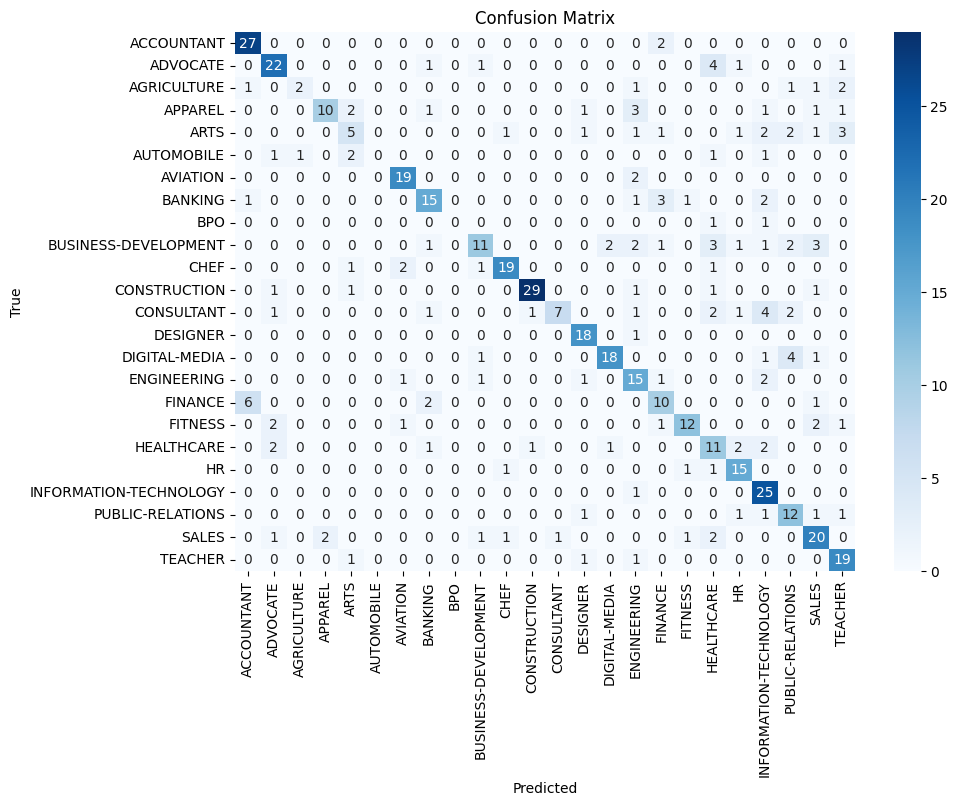

In [18]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Convertir les caractéristiques textuelles en représentation numérique
vectorizer = TfidfVectorizer(max_features=5000)  # Limitez à 5000 caractéristiques pour des performances optimales
X_cv = vectorizer.fit_transform(resume_data['Feature']).toarray()
y_cv = resume_data['Category']

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X_cv, y_cv, test_size=0.2, random_state=42)

# Former un modèle RandomForest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = rf_model.predict(X_test)

# Calculer les métriques d'évaluation
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# Matrice de confusion
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()
